### Getting Started with LangGraph API

In [30]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [31]:
class State(TypedDict):
    messages:Annotated[list, add_messages]
graph_builder = StateGraph(State)

In [32]:
graph_builder 

In [33]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [34]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="qwen/qwen3-32b")
# Or USE
# llm = init_chat_model("groq:llama-3.3-70b-versatile")

In [35]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021BF74079D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021BF7520410>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [36]:
# Node Functionality

def chatbot(state:State):
    return{"messages": [llm.invoke(state["messages"])]}

In [37]:

graph_builder = StateGraph(State)

# Adding Nod
graph_builder.add_node("llmchatbot", chatbot)
# Adding Edge
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

# Compile the graph
graph = graph_builder.compile()

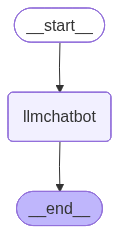

In [38]:
## Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [39]:
response = graph.invoke({"messages":"Hi"})

In [40]:
response["messages"][-1].content

'<think>\nOkay, the user sent "Hi". I need to respond appropriately. Since it\'s a greeting, I should reply with a friendly and welcoming message. Let me check the guidelines to make sure I\'m following the right tone. I should keep it conversational and offer assistance. Maybe something like, "Hello! How can I assist you today?" That sounds good. Let me make sure there are no errors and that it\'s in natural, everyday language.\n</think>\n\nHello! How can I assist you today? 😊'

In [41]:
for event in graph.stream({"messages": "Hi! How are you doing today?"}):
    for value in event.values():
        print(value["messages"][-1].content)

<think>
Alright, the user just asked, "Hi! How are you doing today?" I need to respond appropriately. Let me break this down.

First, the greeting is friendly and open-ended. The user is probably looking for a welcoming reply and maybe starting a conversation. I should acknowledge their greeting warmly.

I should express gratitude for the question and then share a positive state. I need to keep the tone friendly and approachable. Let me check if there are any cultural nuances I should be aware of - probably not necessary here since it's a straightforward greeting.

Next, I should invite them to share what's on their mind. People usually ask how I'm doing because they want to connect. Let me make sure to encourage further conversation without being pushy. Something like "I'm here to help!" would be good.

I need to keep the response concise but not too short. Let me structure it with a greeting, a brief personal status update, and an invitation to talk. Avoid any technical jargon or com

### ChatBot

In [42]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is Langgraph")

{'query': 'What is Langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
   'title': 'What is LangGraph? - GeeksforGeeks',
   'content': 'LangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. By treating workflows as interconnected nodes and edges, LangGraph offers a scalable, transparent and developer-friendly way to design advanced AI systems ranging from simple chatbots to multi-agent system. * ****Enhanced decision-making:**** Models relationships between nodes, enabling AI agents to learn from past actions and feedback. * ****langgraph:**** Framework for building graph-based AI workflows. * Build the workflow graph using LangGraph, adding nodes for classification and response, connecting them with edges and compiling the app. * Send each input through the workflow graph and returns the bot’s response, e

In [43]:
## Customer Function
def multiply(a:int, b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """

In [44]:
tools = [tool, multiply]

In [45]:
llm_with_tool = llm.bind_tools(tools)

In [46]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021BF74079D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021BF7520410>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

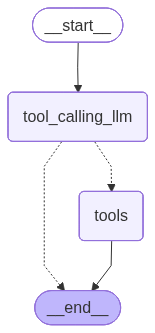

In [47]:
from IPython.display import Image, display

# StateGraph
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Definition 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools", END)

# Compile the Graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
response = graph.invoke({"messages": "What is the recent AI News"})

In [49]:
response

{'messages': [HumanMessage(content='What is the recent AI News', additional_kwargs={}, response_metadata={}, id='f7ceb3d8-bc45-4b49-a3bf-d16b15dc6dd7'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Let me see which tool to use. The available tools are tavily_search and multiply. Multiply is for math, so tavily_search is the right choice.\n\nI need to set up the parameters for tavily_search. The query should be "recent AI news". The user wants recent info, so maybe use the time_range parameter. The options are day, week, month, year. Since they said "recent," maybe "week" is appropriate. Let me check the tool\'s description again. It says time_range should be set when the user explicitly mentions a time period. The user did say "recent," which is a bit vague, but "week" might cover it. Alternatively, maybe "month" to be safer. Hmm.\n\nAlso, the topic parameter. The options are general, news, finance. The user is asking for

In [50]:
response["messages"][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.devdiscourse.com/article/technology/3701698-indias-gccs-embrace-ai-workforce-surge-and-transformation", "title": "India\'s GCCs Embrace AI: Workforce Surge and Transformation - Devdiscourse", "score": 0.6578248, "published_date": "Tue, 18 Nov 2025 10:41:45 GMT", "content": "+ NEWS * NEWS * News # India\'s GCCs Embrace AI: Workforce Surge and Transformation ## With GCCs in India adopting AI, the workforce is projected to reach 3.46 million by 2030, adding 1.3 million jobs. India is witnessing a transformative shift as Global Capability Centres (GCCs) intensify AI adoption, forecasting an increase in the workforce to 3.46 million by 2030, adding over a million jobs, according to a recent report by NLB Services. The Workforce 2.0 Reset report highlights the evolution of GCCs towards AI-native operations, with emerging roles like Cybersecurity and AI Governance Architect

In [51]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI News
================================== Ai Message ==================================
Tool Calls:
  tavily_search (9q1a5btgw)
 Call ID: 9q1a5btgw
  Args:
    query: recent AI news
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.devdiscourse.com/article/technology/3701698-indias-gccs-embrace-ai-workforce-surge-and-transformation", "title": "India's GCCs Embrace AI: Workforce Surge and Transformation - Devdiscourse", "score": 0.6578248, "published_date": "Tue, 18 Nov 2025 10:41:45 GMT", "content": "+ NEWS * NEWS * News # India's GCCs Embrace AI: Workforce Surge and Transformation ## With GCCs in India adopting AI, the workforce is projected to reach 3.46 million by 2030, adding 

In [52]:
## Customer Function

def multiply(a:int, b:int)->int:
    """Multiply a and b
    
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int    
    """

toos = [tool, multiply]

In [53]:
llm_with_tool = llm.bind_tools(tools)

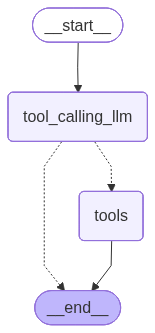

In [54]:
from IPython.display import Image, display

# StateGraph
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Definition 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools", END)

# Compile the Graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:
response =graph.invoke({"messages": "What is 5 multiply by 10"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiply by 10
================================== Ai Message ==================================
Tool Calls:
  multiply (ne5kgxr1c)
 Call ID: ne5kgxr1c
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: multiply

null


In [56]:
response =graph.invoke({"messages": "What is 15 multiply by 9 and 3 plus 6"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 15 multiply by 9 and 3 plus 6
================================== Ai Message ==================================
Tool Calls:
  multiply (ppntcdgse)
 Call ID: ppntcdgse
  Args:
    a: 15
    b: 9
================================= Tool Message =================================
Name: multiply

null


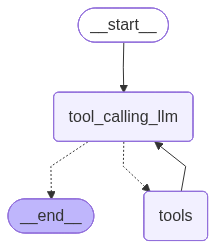

In [57]:
## ReAct Agent Architecture

from IPython.display import Image, display

# StateGraph
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Definition 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools", "tool_calling_llm")

# Compile the Graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [58]:
response =graph.invoke({"messages": "What is the recent AI News and multiply 20 by 3"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI News and multiply 20 by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (vmy263t56)
 Call ID: vmy263t56
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
  multiply (wvqa56ers)
 Call ID: wvqa56ers
  Args:
    a: 20
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.npr.org/2025/11/23/nx-s1-5615410/ai-bubble-nvidia-openai-revenue-bust-data-centers", "title": "Here's why concerns about an AI bubble are bigger than ever - NPR", "content": "Take OpenAI, the ChatGPT maker that set off the AI race in late 2022. Its CEO Sam Altman has said the company is making $20 billion in revenue a year, and it plans to spend $1.4 tr

### Adding Memory in Agentic Graph

In [59]:
response =graph.invoke({"messages": "Hi!, My name is Josh"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi!, My name is Josh
================================== Ai Message ==================================

Hello, Josh! How can I assist you today?


In [60]:
response =graph.invoke({"messages": "Hey! Remind me of my name"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey! Remind me of my name
================================== Ai Message ==================================

I don't have access to your personal information or previous interactions, so I can't recall your name. If you'd like me to address you by name, please share it with me directly!


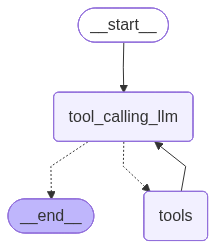

In [61]:

## ReAct Agent Architecture
# StateGraph
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Node Definition 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools", "tool_calling_llm")

# Compile the Graph
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
config = {"configurable":{"thread_id": "1"}}

response =graph.invoke({"messages": "Hi! My name is Josh"}, config=config)

In [63]:
response

{'messages': [HumanMessage(content='Hi! My name is Josh', additional_kwargs={}, response_metadata={}, id='90e5950a-7518-4e4f-8e29-09ca3088c158'),
  AIMessage(content='Hello, Josh! How can I help you today?', additional_kwargs={'reasoning_content': 'Okay, the user said, "Hi! My name is Josh." Let me think about how to respond.\n\nFirst, I need to acknowledge his greeting. Since he introduced himself, a simple "Hello, Josh!" would be polite. Then, I should offer assistance. Maybe say something like, "How can I help you today?" to open the conversation. Keep it friendly and open-ended. I don\'t need to use any functions here because it\'s just a greeting and there\'s no specific request. Just a standard response should suffice. Let me put that together.\n'}, response_metadata={'token_usage': {'completion_tokens': 130, 'prompt_tokens': 1898, 'total_tokens': 2028, 'completion_time': 0.258042892, 'completion_tokens_details': {'reasoning_tokens': 114}, 'prompt_time': 0.085736652, 'prompt_toke

In [64]:
response["messages"][-1].content

'Hello, Josh! How can I help you today?'

In [65]:
response =graph.invoke({"messages": "Hey! Remind me of my name"}, config=config)
print(response["messages"][-1].content)

Hello again! Your name is Josh. How can I assist you further?


### Streaming

In [66]:
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
memory = MemorySaver()

In [67]:
def Chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

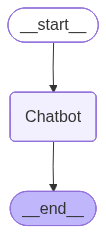

In [68]:
graph = StateGraph(State)

## Node
graph.add_node("Chatbot", chatbot)

# Edges
graph.add_edge(START, "Chatbot")
graph.add_edge("Chatbot", END)

graph_builder = graph.compile(checkpointer=memory)

## Display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [69]:
# Invocation
config = {"configurable":{"thread_id": "1"}}

response = graph_builder.invoke({"messages": "Hi! My name is Josh and like football"}, config)
response

{'messages': [HumanMessage(content='Hi! My name is Josh and like football', additional_kwargs={}, response_metadata={}, id='d4abb1e1-f824-4881-9231-717cd88d04c4'),
  AIMessage(content='<think>\nOkay, Josh mentioned his name and that he likes football. I should respond in a friendly and welcoming manner. I need to acknowledge his name and show interest in football. Maybe ask him what position he plays or if he follows any teams. Keep the conversation open for him to share more. Use emojis to keep it casual. Let me make sure the response is engaging and not too formal.\n</think>\n\nHi Josh! 👋 Nice to meet you! Football is awesome—I love how dynamic the game is. Are you into playing it, or are you more of a fan watching matches? Do you follow any particular teams or players? ⚽😄', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 17, 'total_tokens': 150, 'completion_time': 0.351402018, 'completion_tokens_details': None, 'prompt_time': 0.000

## Streaming

Methods: Stream() and Astream()

- These methods are sync and async methods for streaming back the results.

Additional parameters in streaming modes for graph state

- **Values**: This streams the full state of the graph after each node is called
- **Updates** This streams the updates to the state of the graph after each node is called.

#### Stream SYNC

- Display only Human message

In [76]:
config = {"configurable": {"thread_id": "3"}}

# Stream with "update" mode - shows only what changed per step
for chunk in graph_builder.stream(
    {"messages": "Hi! My name is Josh. And I like to play soccer"},
    config,
    stream_mode="updates"
):
    print(chunk)

{'Chatbot': {'messages': [AIMessage(content='<think>\nOkay, let me try to figure out how to respond to Josh here. He\'s introduced himself multiple times with slight variations. The first time, he wrote "like to play soccer" without the "I". Each time, I corrected him and asked questions to keep the conversation going. Now, he\'s finally written "And I like to play soccer" correctly.\n\nHmm, so maybe he\'s practicing or learning English. My job is to be helpful and encouraging. Since he\'s corrected himself, I should acknowledge that progress. Also, he seems to be testing how I respond each time. I need to keep it friendly and engaging. \n\nThe user might want to continue the conversation about soccer. Maybe they want to talk about their experiences, favorite parts, or goals. I should ask an open-ended question to invite them to share more. Let me check previous responses to avoid repeating the same questions. \n\nIn the last response, I asked about the favorite part or dreams. This ti

#### Values

- Displays both the Humman and AI messages

In [ ]:
# "Values" mode - full state each time
for chunk in graph_builder.stream(
    {"messages": "Hi! My name is Josh. And I like to play soccer"},
    config,
    stream_mode="values"
):
    print(chunk)

{'messages': [HumanMessage(content='Hi! My name is Josh. And like to play soccer', additional_kwargs={}, response_metadata={}, id='0f264eec-52c6-41ef-a3a2-391e43502324'), AIMessage(content="<think>\nOkay, the user told me his name is Josh and he likes to play soccer. I should respond with a friendly greeting to start the conversation. I can use emojis to make the interaction more lively. I'll ask about the team he's on or which club he likes to support to learn more about his interests and continue the conversation. I should keep the tone positive and engaging.\n</think>\n\nHi Josh! 👋 I love that you play soccer—it's such a great sport! 🏆 Do you play for a team, or follow any particular clubs? Maybe you have a favorite position on the field? Let me know, I’d love to hear more! ⚽😄", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 140, 'prompt_tokens': 20, 'total_tokens': 160, 'completion_time': 0.391204654, 'completion_tokens_details': None, 'prompt_time': 

In [78]:
config = {"configurable": {"thread_id": "4"}}

# Stream with "update" mode - shows only what changed per step
for chunk in graph_builder.stream(
    {"messages": "Hi! My name is Josh. And I like to play soccer"},
    config,
    stream_mode="updates"
):
    print(chunk)

{'Chatbot': {'messages': [AIMessage(content='<think>\nOkay, the user introduced himself as Josh and mentioned he likes to play soccer. I need to respond appropriately. First, I should acknowledge his name and interest. Maybe ask a follow-up question to keep the conversation going. Let me check the guidelines. I need to make sure the response is friendly and engaging. Perhaps ask about his favorite position or team. Let me see... Also, maybe mention if he plays any other sports. Keep it open-ended. Let me form a response now.\n</think>\n\nHi Josh! Nice to meet you. Soccer is a fantastic sport—do you have a favorite position to play, or any teams you follow? Also, do you play any other sports? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 21, 'total_tokens': 164, 'completion_time': 0.389936113, 'completion_tokens_details': None, 'prompt_time': 0.000903265, 'prompt_tokens_details': None, 'queue_time': 0.088983349, 'total_time': 0.3

In [80]:
# "Values" mode - full state each time
for chunk in graph_builder.stream(
    {"messages": "I like sprint and marathon race, besides soccer"},
    config,
    stream_mode="values"
):
    print(chunk)

{'messages': [HumanMessage(content='Hi! My name is Josh. And I like to play soccer', additional_kwargs={}, response_metadata={}, id='3d65bda4-c5be-4774-9953-12e78afbb30e'), AIMessage(content='<think>\nOkay, the user introduced himself as Josh and mentioned he likes to play soccer. I need to respond appropriately. First, I should acknowledge his name and interest. Maybe ask a follow-up question to keep the conversation going. Let me check the guidelines. I need to make sure the response is friendly and engaging. Perhaps ask about his favorite position or team. Let me see... Also, maybe mention if he plays any other sports. Keep it open-ended. Let me form a response now.\n</think>\n\nHi Josh! Nice to meet you. Soccer is a fantastic sport—do you have a favorite position to play, or any teams you follow? Also, do you play any other sports? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 143, 'prompt_tokens': 21, 'total_tokens': 164, 'completion_time': 0.38

#### Stream ASYNC

- For more details and full imformation

In [83]:
config = {"configurable": {"thread_id": "3"}}

async for event in graph_builder.astream_events(
    {"messages": "Hi! My name is Josh. And I like to play soccer"},
    config,
    config_version="v2"
):
    print(chunk)

{'Chatbot': {'messages': [AIMessage(content="<think>\nOkay, let's see. The user, Josh, has already mentioned his love for soccer, sprinting, and marathons. He's been discussing how these activities complement each other. Now he's repeated his introduction. Maybe he's just testing or wants to start a new conversation.\n\nI need to respond in a friendly and encouraging way. Since he mentioned soccer again, maybe he wants to focus on that. But he also has interests in sprinting and marathons. I should acknowledge his previous points but maybe pivot to ask a new question to keep the conversation going. Let me check the previous messages to make sure I don't repeat the same questions. \n\nIn his last message, he reiterated his name and soccer. Maybe he wants to connect on a new topic. Perhaps ask about a favorite soccer position again or something else related to his other sports. Alternatively, offer to help with something else like training tips. Keep it positive and open-ended to encoura